<a href="https://colab.research.google.com/github/JigarT10/CNN/blob/main/Object%20Detection%20Fruits/Object_Detection_Fruits.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install ultralytics

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
from ultralytics import YOLO
import xml.etree.ElementTree as ET
import glob
import os
import json
import numpy as np
import random
import shutil
from PIL import Image, ImageDraw

In [ ]:
from google.colab import drive
drive.mount('/gdrive')
%cd /gdrive/MyDrive/Detection Fruits/

Drive already mounted at /gdrive; to attempt to forcibly remount, call drive.mount("/gdrive", force_remount=True).
/gdrive/MyDrive/Detection Fruits


In [ ]:
!ls

annotations  data.yaml	labels			     yolov8s.pt
classes.txt  images	Morning-Fruit-Salad-1-3.jpg


In [ ]:
def xml_to_yolo_bbox(bbox, w, h):
    # xmin, ymin, xmax, ymax
    x_center = ((bbox[2] + bbox[0]) / 2) / w
    y_center = ((bbox[3] + bbox[1]) / 2) / h
    width = (bbox[2] - bbox[0]) / w
    height = (bbox[3] - bbox[1]) / h
    return [x_center, y_center, width, height]

classes = []
input_dir = "annotations/"
output_dir = "labels/"
image_dir = "images/"

# create the labels folder (output directory)
if not os.path.isdir(output_dir):
    os.mkdir(output_dir)

# identify all the xml files in the annotations folder (input directory)
files = glob.glob(os.path.join(input_dir, '*.xml'))
# loop through each 
for fil in files:
    basename = os.path.basename(fil)
    filename = os.path.splitext(basename)[0]
    # check if the label contains the corresponding image file
    if not os.path.exists(os.path.join(image_dir, f"{filename}.jpg")):
        print(f"{filename} image does not exist!")
        continue

    result = []

    # parse the content of the xml file
    tree = ET.parse(fil)
    root = tree.getroot()
    width = int(root.find("size").find("width").text) + 0.0000001
    height = int(root.find("size").find("height").text) + 0.0000001

    for obj in root.findall('object'):
        label = obj.find("name").text
        # check for new classes and append to list
        if label not in classes:
            classes.append(label)
        index = classes.index(label)
        pil_bbox = [int(x.text) for x in obj.find("bndbox")]
        yolo_bbox = xml_to_yolo_bbox(pil_bbox, width, height)
        # convert data to string
        bbox_string = " ".join([str(x) for x in yolo_bbox])
        result.append(f"{index} {bbox_string}")

    if result:
        # generate a YOLO format text file for each xml file
        with open(os.path.join(output_dir, f"{filename}.txt"), "w", encoding="utf-8") as f:
            f.write("\n".join(result))

# generate the classes file as reference
with open('classes.txt', 'w', encoding='utf8') as f:
    f.write(json.dumps(classes))

In [ ]:
!ls

annotations  data.yaml	labels			     yolov8s.pt
classes.txt  images	Morning-Fruit-Salad-1-3.jpg


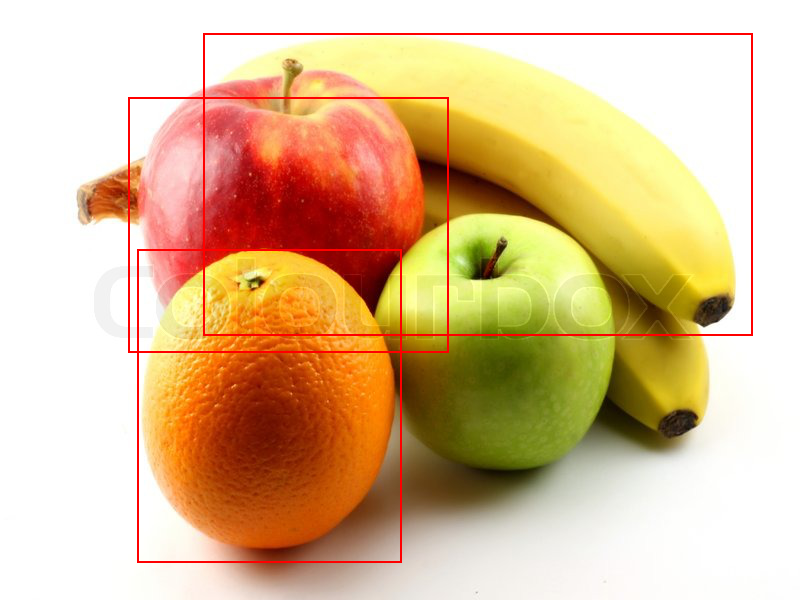

In [ ]:
def yolo_to_xml_bbox(bbox, w, h):
    # x_center, y_center width heigth
    w_half_len = (bbox[2] * w) / 2
    h_half_len = (bbox[3] * h) / 2
    xmin = int((bbox[0] * w) - w_half_len)
    ymin = int((bbox[1] * h) - h_half_len)
    xmax = int((bbox[0] * w) + w_half_len)
    ymax = int((bbox[1] * h) + h_half_len)
    return [xmin, ymin, xmax, ymax]


def draw_image(img, bboxes):
    draw = ImageDraw.Draw(img)
    for bbox in bboxes:
        draw.rectangle(bbox, outline="red", width=2)
    img.save("mixed_13.jpg")
    img.show()


image_filename = "images/mixed_13.jpg"
label_filename = "labels/mixed_13.txt"
bboxes = []

img = Image.open(image_filename)

with open(label_filename, 'r', encoding='utf8') as f:
    for line in f:
        data = line.strip().split(' ')
        bbox = [float(x) for x in data[1:]]
        bboxes.append(yolo_to_xml_bbox(bbox, img.width, img.height))

draw_image(img, bboxes)

In [ ]:
!ls

annotations  data.yaml	labels	      Morning-Fruit-Salad-1-3.jpg
classes.txt  images	mixed_13.jpg  yolov8s.pt


In [ ]:
def copyfiles(fil, root_dir):
    basename = os.path.basename(fil)
    filename = os.path.splitext(basename)[0]

    # copy image
    src = fil
    dest = os.path.join(root_dir, image_dir, f"{filename}.jpg")
    shutil.copyfile(src, dest)

    # copy annotations
    src = os.path.join(label_dir, f"{filename}.txt")
    dest = os.path.join(root_dir, label_dir, f"{filename}.txt")
    if os.path.exists(src):
        shutil.copyfile(src, dest)


label_dir = "labels/"
image_dir = "images/"
lower_limit = 0
files = glob.glob(os.path.join(image_dir, '*.jpg'))

random.shuffle(files)

folders = {"train": 0.8, "val": 0.1, "test": 0.1}
check_sum = sum([folders[x] for x in folders])

assert check_sum == 1.0, "Split proportion is not equal to 1.0"

for folder in folders:
    os.mkdir(folder)
    temp_label_dir = os.path.join(folder, label_dir)
    os.mkdir(temp_label_dir)
    temp_image_dir = os.path.join(folder, image_dir)
    os.mkdir(temp_image_dir)

    limit = round(len(files) * folders[folder])
    for fil in files[lower_limit:lower_limit + limit]:
        copyfiles(fil, folder)
    lower_limit = lower_limit + limit

In [ ]:
!ls

annotations  images	   Morning-Fruit-Salad-1-3.jpg	val
classes.txt  labels	   test				yolov8s.pt
data.yaml    mixed_13.jpg  train


In [ ]:
model = YOLO("yolov8s.pt")  # load a pretrained model (recommended for training)

In [ ]:
!yolo task=detect mode=train model=yolov8s.pt data=data.yaml epochs=100 imgsz=640 batch=32

Ultralytics YOLOv8.0.106 🚀 Python-3.10.11 torch-2.0.1+cu118 CUDA:0 (Tesla T4, 15102MiB)
yolo/engine/trainer: task=detect, mode=train, model=yolov8s.pt, data=data.yaml, epochs=100, patience=50, batch=32, imgsz=640, save=True, save_period=-1, cache=False, device=None, workers=8, project=None, name=None, exist_ok=False, pretrained=False, optimizer=SGD, verbose=True, seed=0, deterministic=True, single_cls=False, rect=False, cos_lr=False, close_mosaic=0, resume=False, amp=True, overlap_mask=True, mask_ratio=4, dropout=0.0, val=True, split=val, save_json=False, save_hybrid=False, conf=None, iou=0.7, max_det=300, half=False, dnn=False, plots=True, source=None, show=False, save_txt=False, save_conf=False, save_crop=False, show_labels=True, show_conf=True, vid_stride=1, line_width=None, visualize=False, augment=False, agnostic_nms=False, classes=None, retina_masks=False, boxes=True, format=torchscript, keras=False, optimize=False, int8=False, dynamic=False, simplify=False, opset=None, workspace

In [ ]:
!ls

annotations  images	   Morning-Fruit-Salad-1-3.jpg	train	    yolov8s.pt
classes.txt  labels	   runs				val
data.yaml    mixed_13.jpg  test				yolov8n.pt


In [ ]:
# !yolo task=detect mode=train model='/gdrive/MyDrive/Detection Fruits/runs/detect/train/weights/last.pt' data=data.yaml epochs=50 imgsz=640

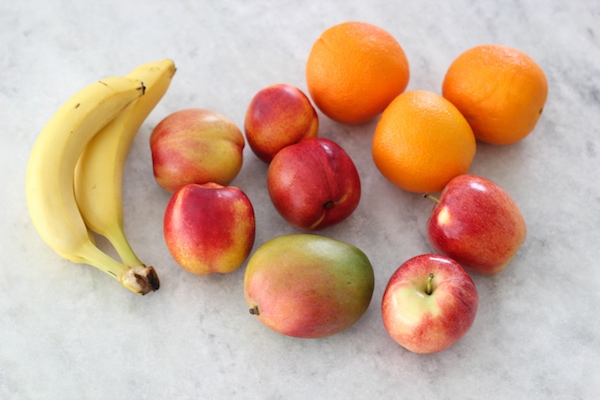

In [ ]:
from IPython.display import Image

Image(filename='Morning-Fruit-Salad-1-3.jpg')

In [ ]:
!yolo task=detect mode=predict model='/gdrive/MyDrive/Detection Fruits/runs/detect/train/weights/last.pt' source='Morning-Fruit-Salad-1-3.jpg'

Ultralytics YOLOv8.0.106 🚀 Python-3.10.11 torch-2.0.1+cu118 CUDA:0 (Tesla T4, 15102MiB)
Model summary (fused): 168 layers, 11126745 parameters, 0 gradients

image 1/1 /gdrive/MyDrive/Detection Fruits/Morning-Fruit-Salad-1-3.jpg: 448x640 7 apples, 2 bananas, 4 oranges, 63.4ms
Speed: 3.1ms preprocess, 63.4ms inference, 2.3ms postprocess per image at shape (1, 3, 640, 640)
Results saved to runs/detect/predict


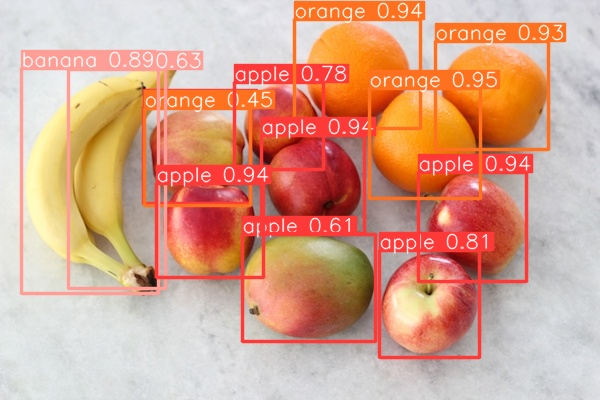

In [ ]:
from IPython.display import Image

Image(filename='/runs/detect/predict/Morning-Fruit-Salad-1-3.jpg')